## 1. 导入依赖

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np
%matplotlib inline

## 2. 模型架构定义

In [2]:
class NPLM(nn.Module):
    def __init__(self, vocab_size=1000, emb_dim=64, context_size=3, hidden_dim=128):
        """
        参数说明：
        vocab_size: 词汇表大小 
        emb_dim: 词嵌入维度
        context_size: 上下文词数 (n-1)
        hidden_dim: 隐藏层维度
        """
        super().__init__()
        
        # 嵌入层：将离散词索引映射为连续向量
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        
        # 全连接层1：上下文向量拼接后投影
        self.fc1 = nn.Linear(context_size * emb_dim, hidden_dim)
        
        # 非线性激活
        self.relu = nn.ReLU()
        
        # 输出层：预测下一个词的概率分布
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
        # 初始化权重
        nn.init.xavier_uniform_(self.embeddings.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)

    def forward(self, x):
        """
        前向传播流程：
        x: 输入词索引序列 [batch_size, context_size]
        """
        # 嵌入层：[batch, context] => [batch, context*emb_dim]
        embeds = self.embeddings(x).view(x.size(0), -1)
        
        # 全连接 + 激活
        hidden = self.relu(self.fc1(embeds))
        
        # 输出层
        logits = self.fc2(hidden)
        return logits

## 3. 数据预处理

In [10]:
text = """
the cat sat on the mat 
the dog chased the cat 
cats like fish and milk
"""

# 构建词汇表
words = text.strip().split()
vocab = Counter(words)
vocab_size = len(vocab)

# 创建词到索引的映射
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# 超参数设置
CONTEXT_SIZE = 3  # 使用3个词预测下一个词
EMB_DIM = 32
HIDDEN_DIM = 64

# 生成训练数据
def make_dataset(words, context_size):
    data = []
    for i in range(context_size, len(words)):
        context = words[i-context_size:i]
        target = words[i]
        data.append((
            torch.tensor([word_to_idx[w] for w in context], dtype=torch.long),
            torch.tensor(word_to_idx[target], dtype=torch.long)
        ))
    return data

dataset = make_dataset(words, CONTEXT_SIZE)
print(f"生成 {len(dataset)} 个训练样本")

# 输出：生成 13 个训练样本

# 查看前5个样本的详细内容
for i in range(13):
    context, target = dataset[i]
    print(f"样本{i+1}:")
    print(f"  上下文索引: {context.tolist()}")
    print(f"  目标索引: {target.item()}")
    print(f"  对应文本: {[idx_to_word[idx] for idx in context.tolist()]} -> {idx_to_word[target.item()]}")

生成 13 个训练样本
样本1:
  上下文索引: [0, 1, 2]
  目标索引: 3
  对应文本: ['the', 'cat', 'sat'] -> on
样本2:
  上下文索引: [1, 2, 3]
  目标索引: 0
  对应文本: ['cat', 'sat', 'on'] -> the
样本3:
  上下文索引: [2, 3, 0]
  目标索引: 4
  对应文本: ['sat', 'on', 'the'] -> mat
样本4:
  上下文索引: [3, 0, 4]
  目标索引: 0
  对应文本: ['on', 'the', 'mat'] -> the
样本5:
  上下文索引: [0, 4, 0]
  目标索引: 5
  对应文本: ['the', 'mat', 'the'] -> dog
样本6:
  上下文索引: [4, 0, 5]
  目标索引: 6
  对应文本: ['mat', 'the', 'dog'] -> chased
样本7:
  上下文索引: [0, 5, 6]
  目标索引: 0
  对应文本: ['the', 'dog', 'chased'] -> the
样本8:
  上下文索引: [5, 6, 0]
  目标索引: 1
  对应文本: ['dog', 'chased', 'the'] -> cat
样本9:
  上下文索引: [6, 0, 1]
  目标索引: 7
  对应文本: ['chased', 'the', 'cat'] -> cats
样本10:
  上下文索引: [0, 1, 7]
  目标索引: 8
  对应文本: ['the', 'cat', 'cats'] -> like
样本11:
  上下文索引: [1, 7, 8]
  目标索引: 9
  对应文本: ['cat', 'cats', 'like'] -> fish
样本12:
  上下文索引: [7, 8, 9]
  目标索引: 10
  对应文本: ['cats', 'like', 'fish'] -> and
样本13:
  上下文索引: [8, 9, 10]
  目标索引: 11
  对应文本: ['like', 'fish', 'and'] -> milk


## 4. 模型训练

In [4]:
# ## 4. 模型训练
# %%
# 初始化模型和优化器
model = NPLM(vocab_size, EMB_DIM, CONTEXT_SIZE, HIDDEN_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练循环
losses = []
for epoch in range(1000):
    total_loss = 0
    for context, target in dataset:
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        logits = model(context.unsqueeze(0))  # 添加batch维度
        
        # 计算损失
        loss = criterion(logits, target.unsqueeze(0))
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        total_loss += loss.item()
    
    # 记录损失
    losses.append(total_loss/len(dataset))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

Epoch 0, Loss: 2.4732
Epoch 100, Loss: 0.0032
Epoch 200, Loss: 0.0006
Epoch 300, Loss: 0.0002
Epoch 400, Loss: 0.0001
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


## 5. 词向量可视化

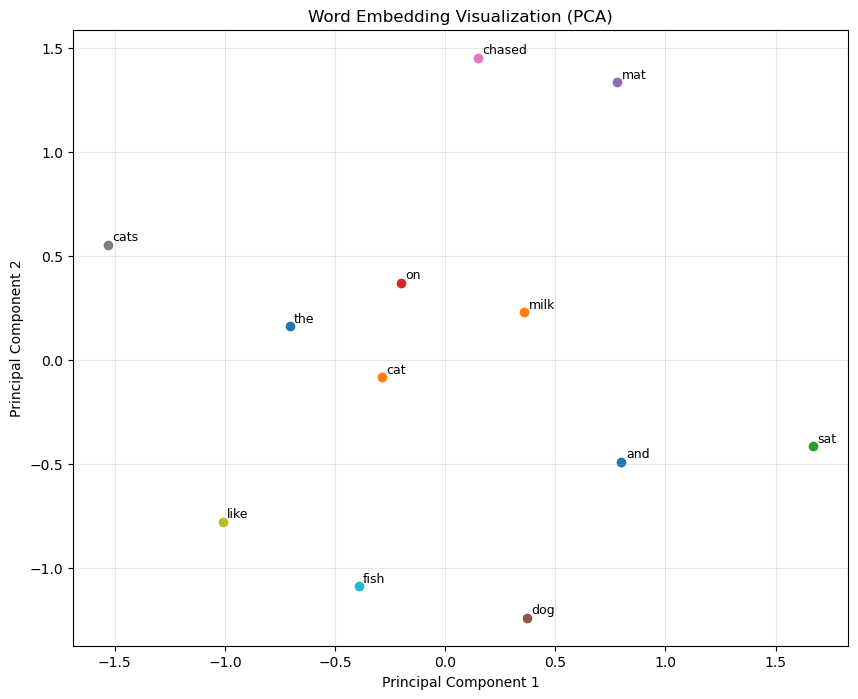

In [6]:
## 5. 词向量可视化
# %%
# 提取嵌入权重
embeddings = model.embeddings.weight.detach().numpy()

# PCA降维
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# 绘制散点图
plt.figure(figsize=(10,8))
for i, word in idx_to_word.items():
    plt.scatter(reduced[i,0], reduced[i,1], marker='o')
    plt.text(reduced[i,0]+0.02, reduced[i,1]+0.02, word, fontsize=9)

plt.title("Word Embedding Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.show()

## 6. 预测示例

In [7]:
def predict(context_words, top_k=3):
    # 转换输入
    context_idx = torch.tensor(
        [word_to_idx[w] for w in context_words], 
        dtype=torch.long
    )
    
    # 前向计算
    with torch.no_grad():
        logits = model(context_idx.unsqueeze(0))
        probs = torch.softmax(logits, dim=1)
    
    # 获取top_k预测
    top_probs, top_indices = torch.topk(probs, top_k)
    
    # 输出结果
    print(f"输入上下文: {context_words}")
    for i, (prob, idx) in enumerate(zip(top_probs[0], top_indices[0])):
        print(f"{i+1}. {idx_to_word[idx.item()]}: {prob.item():.2%}")

# 测试预测
predict(["the", "cat", "sat"])  # 预期预测 "on"
predict(["cats", "like", "fish"])  # 预期预测 "and"

输入上下文: ['the', 'cat', 'sat']
1. on: 100.00%
2. like: 0.00%
3. the: 0.00%
输入上下文: ['cats', 'like', 'fish']
1. and: 100.00%
2. milk: 0.00%
3. on: 0.00%


## 7. 扩展分析

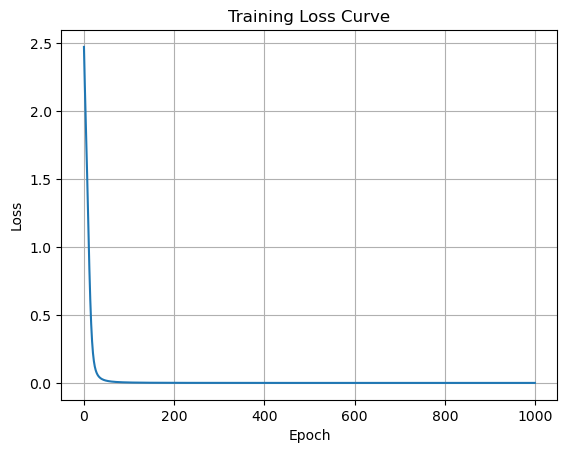

'cat'与'cats'余弦相似度: -0.15
'cat'与'dog'余弦相似度: 0.01


In [9]:
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 词向量相似度分析
def cosine_similarity(word1, word2):
    vec1 = embeddings[word_to_idx[word1]]
    vec2 = embeddings[word_to_idx[word2]]
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

print(f"'cat'与'cats'余弦相似度: {cosine_similarity('cat','cats'):.2f}")
print(f"'cat'与'dog'余弦相似度: {cosine_similarity('cat','dog'):.2f}")